# Modeling with Random Forest Classifier with and without PCA
## Additionally I added a small portion of XGBoost just for my own exploration (you can ignore if you want to)

In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/545_Group_Project/df_for_model.csv'
df = pd.read_csv(file_path)

# Just a quick checking to see if dataframe is correct

In [ ]:
df.head(2)

,product_name,ingredients_text,serving_size,additives_n,additives,additives_en,nutrition_grade_fr,energy_100g,fat_100g,saturated_fat_100g,...,vitamin_c_100g,calcium_100g,iron_100g,organic_label,nutrition_score_100g,nutrition_grade,cleaned_ingredients,cleaned_ingredients_new,tokenized_ingredients,mean_embedding
0,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0.0,[ peanuts ] [ wheat-flour ] [ flour ] [ sug...,NaN,b,1941.0,17.86,0.00,...,0.0,0.071,0.00129,0,0.0,4,"peanuts, wheat flour, sugar, rice flour, tapio...",peanuts wheat flour sugar rice flour tapioca s...,"[185, 23629, 1116, 11773, 15068, 6656, 7738, 1...",7392.868421
1,Granola Cranberry And Acai,"Whole rolled oats, milled cane sugar, vegetabl...",55 g (0.5 cup),0.0,[ whole-rolled-oats ] [ rolled-oats ] [ oats...,NaN,c,1824.0,10.91,0.91,...,0.0,0.036,0.00262,0,6.0,3,"whole rolled oats, milled cane sugar, vegetabl...",whole rolled oats milled cane sugar vegetable ...,"[2006, 3733, 184, 9971, 6159, 1174, 14671, 665...",6923.730769


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91466 entries, 0 to 91465
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_name             91466 non-null  object 
 1   ingredients_text         91466 non-null  object 
 2   serving_size             91466 non-null  object 
 3   additives_n              91466 non-null  float64
 4   additives                91461 non-null  object 
 5   additives_en             62159 non-null  object 
 6   nutrition_grade_fr       91466 non-null  object 
 7   energy_100g              91466 non-null  float64
 8   fat_100g                 91466 non-null  float64
 9   saturated_fat_100g       91466 non-null  float64
 10  trans_fat_100g           91466 non-null  float64
 11  cholesterol_100g         91466 non-null  float64
 12  carbohydrates_100g       91466 non-null  float64
 13  sugars_100g              91466 non-null  float64
 14  fiber_100g            

In [ ]:
df.columns

Index(['product_name', 'ingredients_text', 'serving_size', 'additives_n',
       'additives', 'additives_en', 'nutrition_grade_fr', 'energy_100g',
       'fat_100g', 'saturated_fat_100g', 'trans_fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin_a_100g', 'vitamin_c_100g',
       'calcium_100g', 'iron_100g', 'organic_label', 'nutrition_score_100g',
       'nutrition_grade', 'cleaned_ingredients', 'cleaned_ingredients_new',
       'tokenized_ingredients', 'mean_embedding'],
      dtype='object')

## We did a good job cleaning along the way, but we are going to have to clean this dataframe a little more to get a proper matrix to feed into our machine learning models
1. Get rid unnamed, product name, ingredients_text, serving_size (since that can be described by the macronutrients), additives, additives_en, nutrition_grade_fr (since we handled this nutrition_grade for numeric values), we can now get rid of all ingreident columns with text but we can keep mean_embedding.

2. And of course we are going to have to seperate the organic label for our testing and training data

In [ ]:
drop_list = ['product_name', 'ingredients_text', 'serving_size', 'additives_n', 'additives', 'additives_en', 'nutrition_grade_fr', 'cleaned_ingredients', 'cleaned_ingredients_new', 'tokenized_ingredients']
df.drop(drop_list, axis=1, inplace=True)

In [ ]:
df.head()

,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,organic_label,nutrition_score_100g,nutrition_grade,mean_embedding
0,1941.0,17.86,0.00,0.0,0.0,60.71,17.86,7.1,17.86,0.63500,0.250,0.000000,0.0,0.071,0.00129,0,0.0,4,7392.868421
1,1824.0,10.91,0.91,0.0,0.0,74.55,25.45,5.5,9.09,0.25400,0.100,0.000000,0.0,0.036,0.00262,0,6.0,3,6923.730769
2,2389.0,42.86,7.14,0.0,0.0,25.00,14.29,7.1,25.00,0.54356,0.214,0.000000,0.0,0.071,0.00514,0,14.0,2,7604.666667
3,1255.0,0.00,0.00,0.0,0.0,83.33,66.67,10.0,0.00,0.00000,0.000,0.000000,0.0,0.000,0.00000,0,8.0,3,7835.000000
4,1046.0,0.00,0.00,0.0,0.0,62.50,52.50,7.5,2.50,0.00000,0.000,0.001125,0.0,0.050,0.00360,0,8.0,3,9077.000000


# Another important aspect of this data that we have to address is the imbalance.

In [ ]:
print("Showing Imbalanced Data\n", df['organic_label'].value_counts(), sep = "")

Showing Imbalanced Data
organic_label
0    80036
1    11430
Name: count, dtype: int64


# We see that there is ~80k non organic foods, but only ~11k organic foods.  We also see in the cell below we have some NaN values.  Luckily it is such a small number of NaN values that we can just drop those rows.

In [ ]:
df.isnull().values.ravel().sum()

5

In [ ]:
column_nan_count = df.isnull().sum()
print("NaN count per column:")
print(column_nan_count)

NaN count per column:
energy_100g             0
fat_100g                0
saturated_fat_100g      0
trans_fat_100g          0
cholesterol_100g        0
carbohydrates_100g      0
sugars_100g             0
fiber_100g              0
proteins_100g           0
salt_100g               0
sodium_100g             0
vitamin_a_100g          0
vitamin_c_100g          0
calcium_100g            0
iron_100g               0
organic_label           0
nutrition_score_100g    0
nutrition_grade         0
mean_embedding          5
dtype: int64


# Dealing with some nan values that SMOTE cannot compute. Luckily this imputation is so minor.  We only have 5 rows that show NaN values and they must have just been rows with missing ingredients list since they are from the mean_embedding feature.

So lets now address the NaN values by dropping those rows

Dropping Rows:

* df.dropna(): Removes rows with any missing values.

**Noticed the shapes changed below**

In [ ]:
df.shape

(91466, 19)

In [ ]:
# Drop rows with Nan Values
df.dropna(inplace=True)

In [ ]:
df.shape

(91461, 19)

# SMOTE
* scikitlearn actually will identify the minority group for you and update accordingly (it is completely abstracted)
This is nice, but to get a better understanding of how SMOTE works this was helpful:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In a short sentence, smote uses a kNN algorithm to find neighbors of similarity in (high) dimensional space, finds the line between points and then synthesis data based on a point on that line.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# X, y df seperation
X = df.drop(['organic_label'], axis=1)
y = df['organic_label']

# Split the data into training and testing sets
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

# Apply smote
smote = SMOTE(random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original dataset shape: {np.bincount(y_train)}")
print(f"Resampled dataset shape: {np.bincount(y_train_smote)}")

Original dataset shape: [64007  9161]
Resampled dataset shape: [64007 64007]


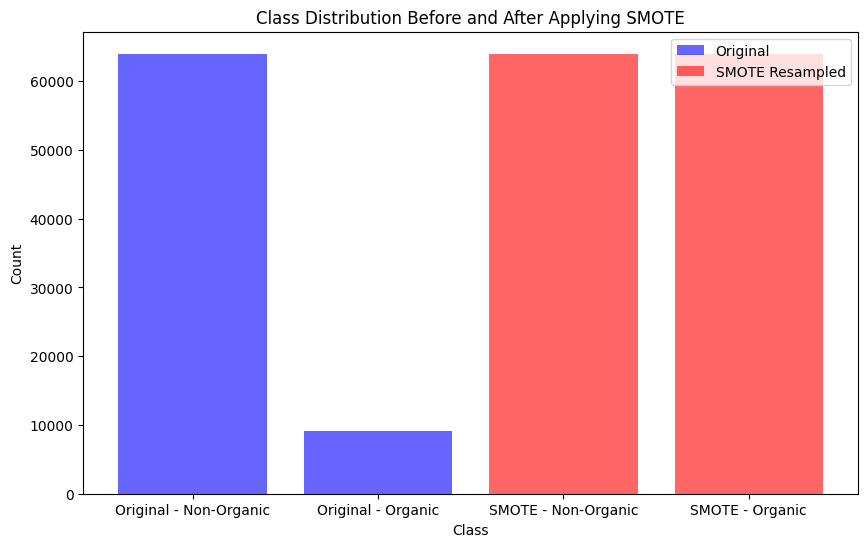

In [ ]:
import matplotlib.pyplot as plt

# Plot the original and resampled dataset shapes
original_counts = np.bincount(y_train)
resampled_counts = np.bincount(y_train_smote)

plt.figure(figsize=(10, 6))
plt.bar(['Original - Non-Organic', 'Original - Organic'], original_counts, color='blue', alpha=0.6, label='Original')
plt.bar(['SMOTE - Non-Organic', 'SMOTE - Organic'], resampled_counts, color='red', alpha=0.6, label='SMOTE Resampled')
plt.xlabel('Class')
plt.legend()
plt.title('Class Distribution Before and After Applying SMOTE')
plt.ylabel('Count')
plt.show()


# Great! Now our data is balanced!

Below you will see our efforts to use Random Forest Classifier to try to predict/classify non orgnanic and organic foods.  This was very interesting because the imbalance data like we have can make our accuracy score high, which can be misleading. Thus other metrics are important as well.

**To get a more comprehensive understanding of our models performance, we will look at accuracy, but also consider evaluating metrics like: **

1. Precision: The ratio of true positive predictions to the total predicted positives.

2. Recall: The ratio of true positive predictions to the total actual positives.

3. F1 Score: The harmonic mean of precision and recall.

4. ROC-AUC: The area under the receiver operating characteristic curve.

5. Confusion Matrix: breakdown of true positives, false positives, true negatives, and false negatives.


With all those things being calculated, we are also trying to get those metrics to be the best as we can.  The method that I am choosing here is ***hyperparameter tuning with cross validation***.
For example, we spent a lot of time trying all these permutations

```
param_grid = {
  'n_estimators': [100, 120, 150, 200, 250, 300],
  'max_depth': [10, 20, 30, 50, 75, 100],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'bootstrap': wkept true
  "criterion = [gini, entroy, gini,log_loss}
  ```
Originally we started out with these params:
```
  randforest_model = RandomForestClassifier(n_estimators= 300, max_depth = 50, random_state = 42, class_weight="balanced", criterion = "entropy")
```
And it yeilded
```
Precision: 0.5355819125277984
Recall: 0.6368444248567651
F1 Score: 0.5818401449567143
ROC AUC Score: 0.8944850270869589
Confusion Matrix:
[[14771  1253]
 [  824  1445]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     16024
           1       0.54      0.64      0.58      2269

    accuracy                           0.89     18293
   macro avg       0.74      0.78      0.76     18293
weighted avg       0.90      0.89      0.89     18293

Acc score:
0.8864593013721096
```
After many permutations later we found our best performing: which you can see down below.  It is good to note this while the recall dropped by a small amount, the precision did increase significantly.  This is because we have this trade off between the two usually.  The accuracy, which is not the best metric, also increased, and the number of false positives and false negatives decreased as well. We also tried increasing the max_depth to larger numbers with the same parameters but were yielding similar if not the same results.  So this set of parameters is optimized for computational efficiency too.

**Although other metrics are good to use, for us, we focused on precision as it seemed the most important metric because when you label a sample as organic, it truly is organic to avoid false claims.  I.e. it's more important to ensure that the positive predictions made actually correct, even if it means potentially missing some actual cases; simillar to how people handle medical diagnosis.**





In [ ]:
# Import required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Initialize model with default parameters and fit it on the training set
randforest_model = RandomForestClassifier(n_estimators= 120, max_depth = 30, random_state = 42, class_weight="balanced", criterion = "gini") # we are keping class weight as balanced as it performs well on imbalanced data

# 5-fold cross validation to check if we are ok with the data quality and hyperparamters: -> ran many times and hyperparams above are best!
cv_scores = cross_val_score(randforest_model, X_train_smote, y_train_smote, cv=5, scoring="f1")
print(f"Cross-Validation F1: {cv_scores}")
print(f"Mean F1: {cv_scores.mean()}")

randforest_model.fit(X_train_smote, y_train_smote)

# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = randforest_model.predict(X_test)

# Find the accuracy and store the value in `rf_acc`
rf_acc = randforest_model.score(X_test, y_test)

# Compute the confusion matrix and save it to `rf_confusion`
rf_confusion = confusion_matrix(y_test, y_pred)

y_prob = randforest_model.predict_proba(X_test)[:, 1] # Probabilities for ROC AUC

# precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc}")

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# classification report
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

# Acc score
print(f"Acc score:{rf_acc}")

Cross-Validation F1: [0.79890696 0.95397649 0.95469132 0.9515311  0.95496113]
Mean F1: 0.9228134004019134
Precision: 0.6100818612666954
Recall: 0.624063464081093
F1 Score: 0.6169934640522876
ROC AUC Score: 0.9058706178282158
Confusion Matrix:
[[15119   905]
 [  853  1416]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     16024
           1       0.61      0.62      0.62      2269

    accuracy                           0.90     18293
   macro avg       0.78      0.78      0.78     18293
weighted avg       0.90      0.90      0.90     18293

Acc score:0.9038976657737933


We are focusing on precision: by tuning our hyperparameters and using cross-validation to tune, we managed to get the precision from .54 to .61 which is significant

# I want to see if we can get the Precision and Recal score better with some other techniques/methods

# But first let's just see what important features there are

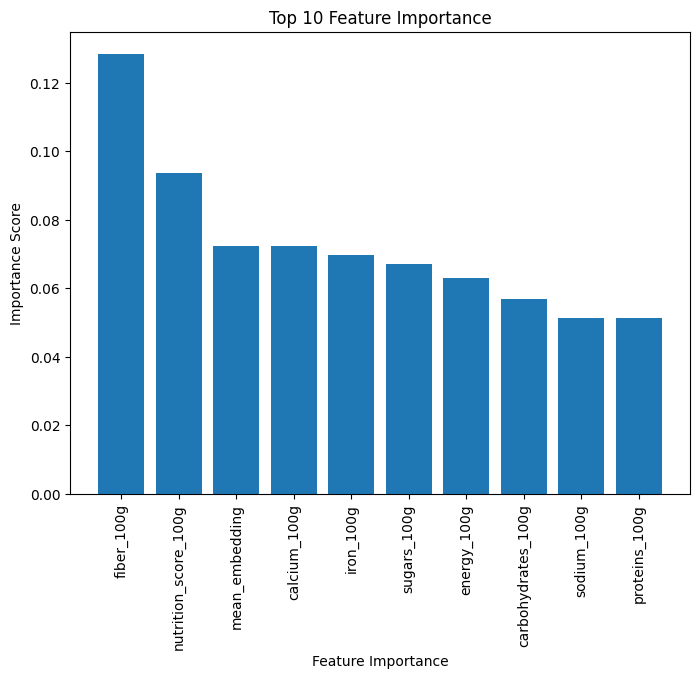

In [ ]:
# get feature importnce using built-in feature importance
importance = randforest_model.feature_importances_

# Get the top 10 and Create a DataFrame `feature_importance_df`
feature_importance_df = pd.DataFrame({
    "Feature": X_train_smote.columns,
    "Feature Importance": importance
    })

feature_importance_df = feature_importance_df.sort_values(by = 'Feature Importance', ascending = False).head(10)

# Visualize the top 10 feature importance using a barplot
plt.figure(figsize=(8, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Feature Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Importance Score')
plt.title('Top 10 Feature Importance')
# did not like the rotation
plt.xticks(rotation=90)
plt.show()
#plt.xticks(rotation=45)

This is great.  We are seeing some confident things that we even saw with our clustering!  We saw that clustering on fiber plays a role some distinction of organic and non organic foods (n=2) we see that the nutriition score given by the dataset that we converted into numerical values really is also a good indicator, and what is so neat is that the feature extraction bert tokinization that we did on the ingredients list is actually important in comparison to other features.  Maybe I just have a soft stop bcause this was a lot of work tokenizing and learning about BERT, but I'm so happy it turned out this way.

And when we clustered on fats, we saw very little correlation! This is what we are seeing here!

# OK, now I am going to run PCA on the dataset to hopefully reduce the dimensions, and maybe see significant improvement performance metrics (again, specifically Precision). Stay Tuned!

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Intermediate step to address fac that PCA is not scale-invariant
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train_smote)
X_test_scaled = scale.transform(X_test)

# Instantiate and Fit PCA
pca = PCA()
pca.fit(X_train_scaled)

PCA()

In [ ]:
# Save the explained variance ratios into variable called "explained_variance_ratios"
np.set_printoptions(suppress = True)

explained_variance_ratios = pca.explained_variance_ratio_
# print(explained_variance_ratios)
# Save the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr = np.cumsum(explained_variance_ratios)
print(cum_evr)

[0.27431754 0.41767201 0.53364764 0.62083388 0.69360342 0.74918347
 0.80254224 0.84929336 0.88736121 0.92239845 0.94579224 0.96352129
 0.97996643 0.99113322 0.99803542 0.99963336 1.         1.        ]


Text(0.5, 1.0, 'Cumulative Explained Variance vs. Number of PCA Components')

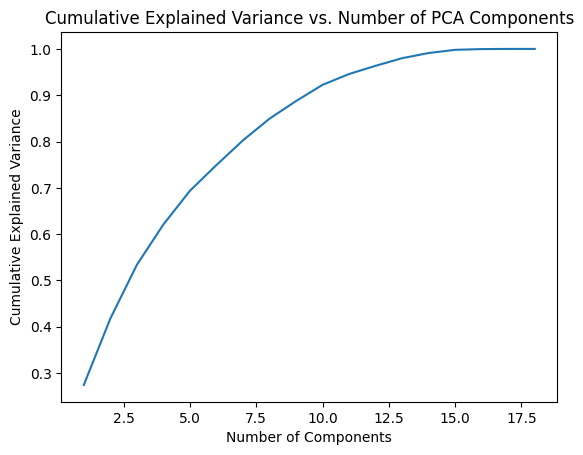

In [ ]:
# find optimal num components to use (n) by plotting explained variance ratio (2 points)
x_ticks = np.arange(len(cum_evr)) +1
plt.plot(size = [8,6])
sns.lineplot(x = x_ticks, y = cum_evr)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title("Cumulative Explained Variance vs. Number of PCA Components")

# My guess that based on this graph we might not really see any improvement.  The elbow is so high almost around 15!  The number of components really has not significantly dropped

We tried 5, 10, 15, 17 -> and of course 15 was the best

In [ ]:
# Get transformed set of principal components on x_test

# 1. Refit and transform on training with parameter n (as deduced from the last step)
n = 15
pca = PCA(n_components = n)
X_train_pca = pca.fit_transform(X_train_scaled)

# 2. Transform on Testing Set and store it as `X_test_pca`
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model -> used to keep consistent to other model for fair assessment
randforest_model = RandomForestClassifier(n_estimators=120, max_depth=30, random_state=seed, class_weight="balanced", criterion = "gini")

# Perform k-fold cross-validation -> because above params are used this step is not as important but still want to keep in
cv_scores = cross_val_score(randforest_model, X_train_pca, y_train_smote, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean()}")


Cross-Validation F1 Scores: [0.86334805 0.91153287 0.91043349 0.91221899 0.91128601]
Mean F1 Score: 0.9017638819788985


# Mean F1 Score: ~ 0.9018

**This high mean F1 score shows that our model is effective in balancing precision and recall across the different cross-validation folds**

In [ ]:
# Fit model on the entire training data
randforest_model.fit(X_train_pca, y_train_smote)

# Predict on the PCA-transformed test set
y_pred = randforest_model.predict(X_test_pca)
y_prob = randforest_model.predict_proba(X_test_pca)[:, 1]

# Calculate Metrics
rf_acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the Metrics
print(f"Accuracy: {rf_acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{report}")


Accuracy: 0.8685289454982781
Precision: 0.478895096213532
Recall: 0.6800352578228295
F1 Score: 0.5620105627390275
ROC AUC Score: 0.8919839582846973
Confusion Matrix:
[[14345  1679]
 [  726  1543]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     16024
           1       0.48      0.68      0.56      2269

    accuracy                           0.87     18293
   macro avg       0.72      0.79      0.74     18293
weighted avg       0.89      0.87      0.88     18293



# Analysis: Random Forest Classifier With PCA and Without PCA

1. Precision and Recall:

* Our model without PCA has higher precision but lower recall for class 1 (organic), meaning it's better at avoiding false positives but misses more true positives.

* Our model with PCA, the recall actually improves (more true positives detected) but precision drops (more false positives). This may suggest that PCA may lead to loss of some informative features important for correctly predicting class 1, hence increasing the false positives.  PCA sometimes cannot retain all information.

2. Accuracy:

* Actually both models have high accuracy, but the model without PCA has a slightly better overall accuracy (90% vs. 87%).  This again isn't the main metric we should be focussing on because of our data imbalance.

3. F1 Score:

* The F1 Score, balancing precision and recall, is higher with out model without PCA. This shows that the model without PCA is slightly better at handling the balance act between true positives and false positives.

4. ROC AUC Score:

* Both models actually have high ROC AUC scores, demonstrating good overall performance in distinguishing between classes. The score is slightly higher with our model without PCA (0.91 vs. 0.89).

5. Confusion Matrix:

* Yes, they are confusing :) Our model without PCA, has fewer false positives and false negatives compared to model with PCA, suggesting better classification accuracy without dimensionality reduction.

# Potential Reasonings For This:

1. I think PCA is suppose to do a good job of reduces dimensionality by capturing the most variance but also retaining importance/information, but sometimes, and in our case, we can lose important details for distinguishing between classes, hence drop in precision with our PCA model.

2. Our data was very imbalance. Maybe in doing PCA certain features important for the minority class (organic) could be overshadowed by majority class features during the datas transformation with PCA.

* We tried to decrease the number of principle components, which obviously was worse, and we even tried increasing the number of principle components to retain more variance.  This did not work as we can see with the cummulative explained variance graph.  It is not a great showing for PCA.

# **Conclusion on RFC models:**
While PCA can help with dimensionality reduction, it might cause information loss affecting the model's ability to accurately classify the minority class in an imbalanced dataset. The other caveat is that with PCA, Random Forest Classifier becomes very unexplainable in terms of features.  We really focused more on precision as a metric and managed to get the model without PCA from 0.54 to 0.61 precision by just tuning the hyperparameters (cv).  We focused on this metric because we thought we wanted to get as many true positives as possible i.e. looking at overall positves and how many are actually correct (TP/ TP+FP).  We could have used other metrics like recall to see the cost of misclasssification, or F1 to see the balance between precision and recall (harmonic mean), or even the confusion matrix, but in this instance we thought precision was a good metric.

# **Future:**
Try some more feature extraction, maybe try different parameters, or try another type of resampling, ADASYN (Adaptive Synthetic Sampling), adjust the decision threshold to balance precision and recall, Generative Adversarial Networks (GANs) - generate synthetic data to augment the training set, especially for the minority class, maybe try different forms of dimensional reduction.

# XGBoost PlayGround (just as a side playground to mess around with boosting this is not for the project, more just for me to learn)

**After talking to Khanh about our modeling.  She mentioned that if I wanted I could try XGBoost model just for my interests.  Here is a small portion of my little experimentations with Boosting.  If you want you can ignore this part as I think the model we have done so far is sufficient, but I thought it would be nice to explore for my edification.**


In [ ]:
# Initialize the XGBoost model
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', early_stopping_rounds=10)
eval_set = [(X_test, y_test)]
# Train the model
xgb_model.fit(X_train_smote, y_train_smote, eval_set=eval_set)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:54:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.63083
[1]	validation_0-logloss:0.59266
[2]	validation_0-logloss:0.56676
[3]	validation_0-logloss:0.54638
[4]	validation_0-logloss:0.53069
[5]	validation_0-logloss:0.51783
[6]	validation_0-logloss:0.50109
[7]	validation_0-logloss:0.48154
[8]	validation_0-logloss:0.46678
[9]	validation_0-logloss:0.46025
[10]	validation_0-logloss:0.45344
[11]	validation_0-logloss:0.44727
[12]	validation_0-logloss:0.43882
[13]	validation_0-logloss:0.43478
[14]	validation_0-logloss:0.43278
[15]	validation_0-logloss:0.42810
[16]	validation_0-logloss:0.41968
[17]	validation_0-logloss:0.41741
[18]	validation_0-logloss:0.40882
[19]	validation_0-logloss:0.40170
[20]	validation_0-logloss:0.40070
[21]	validation_0-logloss:0.39878
[22]	validation_0-logloss:0.39466
[23]	validation_0-logloss:0.38945
[24]	validation_0-logloss:0.38822
[25]	validation_0-logloss:0.38484
[26]	validation_0-logloss:0.38134
[27]	validation_0-logloss:0.37867
[28]	validation_0-logloss:0.37769
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict on the test set
y_pred = xgb_model.predict(X_test_scaled)
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{report}")


Accuracy: 0.1240365167003772
Precision: 0.1240365167003772
Recall: 1.0
F1 Score: 0.22069837564439257
ROC AUC Score: 0.5094323174779479
Confusion Matrix:
[[    0 16024]
 [    0  2269]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16024
           1       0.12      1.00      0.22      2269

    accuracy                           0.12     18293
   macro avg       0.06      0.50      0.11     18293
weighted avg       0.02      0.12      0.03     18293



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[0]	validation_0-logloss:0.38222
[1]	validation_0-logloss:0.39805
[2]	validation_0-logloss:0.41982
[3]	validation_0-logloss:0.44578


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.47471
[5]	validation_0-logloss:0.50577
[6]	validation_0-logloss:0.53833
[7]	validation_0-logloss:0.57196
[8]	validation_0-logloss:0.60632
[9]	validation_0-logloss:0.64114
[0]	validation_0-logloss:0.36599
[1]	validation_0-logloss:0.36145
[2]	validation_0-logloss:0.36034


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-logloss:0.35964
[4]	validation_0-logloss:0.36213
[5]	validation_0-logloss:0.36463
[6]	validation_0-logloss:0.36656
[7]	validation_0-logloss:0.36889
[8]	validation_0-logloss:0.37132
[9]	validation_0-logloss:0.37248
[10]	validation_0-logloss:0.37373
[11]	validation_0-logloss:0.37581
[12]	validation_0-logloss:0.37680
[13]	validation_0-logloss:0.37733
[0]	validation_0-logloss:0.36037
[1]	validation_0-logloss:0.34826
[2]	validation_0-logloss:0.34168
[3]	validation_0-logloss:0.33764
[4]	validation_0-logloss:0.33388
[5]	validation_0-logloss:0.33184
[6]	validation_0-logloss:0.32740
[7]	validation_0-logloss:0.32594
[8]	validation_0-logloss:0.32402
[9]	validation_0-logloss:0.32302
[10]	validation_0-logloss:0.31960


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-logloss:0.31913
[12]	validation_0-logloss:0.31686
[13]	validation_0-logloss:0.31614
[14]	validation_0-logloss:0.31545
[15]	validation_0-logloss:0.31419
[16]	validation_0-logloss:0.31339
[17]	validation_0-logloss:0.31217
[18]	validation_0-logloss:0.31202
[19]	validation_0-logloss:0.31231
[20]	validation_0-logloss:0.31173
[21]	validation_0-logloss:0.31017
[22]	validation_0-logloss:0.30916
[23]	validation_0-logloss:0.30742
[24]	validation_0-logloss:0.30696
[25]	validation_0-logloss:0.30647
[26]	validation_0-logloss:0.30525
[27]	validation_0-logloss:0.30444
[28]	validation_0-logloss:0.30410
[29]	validation_0-logloss:0.30360
[30]	validation_0-logloss:0.30336
[31]	validation_0-logloss:0.30234
[32]	validation_0-logloss:0.30178
[33]	validation_0-logloss:0.30085
[34]	validation_0-logloss:0.30056
[35]	validation_0-logloss:0.30017
[36]	validation_0-logloss:0.29884
[37]	validation_0-logloss:0.29815
[38]	validation_0-logloss:0.29778
[39]	validation_0-logloss:0.29722
[40]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.30380
[11]	validation_0-logloss:0.30183
[12]	validation_0-logloss:0.30027
[13]	validation_0-logloss:0.29978
[14]	validation_0-logloss:0.29863
[15]	validation_0-logloss:0.29793
[16]	validation_0-logloss:0.29721
[17]	validation_0-logloss:0.29473
[18]	validation_0-logloss:0.29361
[19]	validation_0-logloss:0.29184
[20]	validation_0-logloss:0.28933
[21]	validation_0-logloss:0.28787
[22]	validation_0-logloss:0.28731
[23]	validation_0-logloss:0.28594
[24]	validation_0-logloss:0.28513
[25]	validation_0-logloss:0.28312
[26]	validation_0-logloss:0.28241
[27]	validation_0-logloss:0.28084
[28]	validation_0-logloss:0.27967
[29]	validation_0-logloss:0.27886
[30]	validation_0-logloss:0.27748
[31]	validation_0-logloss:0.27702
[32]	validation_0-logloss:0.27641
[33]	validation_0-logloss:0.27449
[34]	validation_0-logloss:0.27382
[35]	validation_0-logloss:0.27236
[36]	validation_0-logloss:0.27208
[37]	validation_0-logloss:0.27152
[38]	validation_0-logloss:0.27131
[39]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-logloss:0.32649
[4]	validation_0-logloss:0.32077
[5]	validation_0-logloss:0.31573
[6]	validation_0-logloss:0.31148
[7]	validation_0-logloss:0.30671
[8]	validation_0-logloss:0.30428
[9]	validation_0-logloss:0.30119
[10]	validation_0-logloss:0.29881
[11]	validation_0-logloss:0.29595
[12]	validation_0-logloss:0.29396
[13]	validation_0-logloss:0.29226
[14]	validation_0-logloss:0.29047
[15]	validation_0-logloss:0.28898
[16]	validation_0-logloss:0.28800
[17]	validation_0-logloss:0.28676
[18]	validation_0-logloss:0.28595
[19]	validation_0-logloss:0.28441
[20]	validation_0-logloss:0.28191
[21]	validation_0-logloss:0.28134
[22]	validation_0-logloss:0.27967
[23]	validation_0-logloss:0.27745
[24]	validation_0-logloss:0.27666
[25]	validation_0-logloss:0.27523
[26]	validation_0-logloss:0.27418
[27]	validation_0-logloss:0.27363
[28]	validation_0-logloss:0.27260
[29]	validation_0-logloss:0.27149
[30]	validation_0-logloss:0.27074
[31]	validation_0-logloss:0.26960
[32]	validation_0-log

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-logloss:0.34530
[0]	validation_0-logloss:0.36046
[1]	validation_0-logloss:0.34927
[2]	validation_0-logloss:0.34112
[3]	validation_0-logloss:0.33552
[4]	validation_0-logloss:0.33175
[5]	validation_0-logloss:0.32748
[6]	validation_0-logloss:0.32590
[7]	validation_0-logloss:0.32488
[8]	validation_0-logloss:0.32280
[9]	validation_0-logloss:0.32094
[10]	validation_0-logloss:0.32051
[11]	validation_0-logloss:0.31953


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-logloss:0.31734
[13]	validation_0-logloss:0.31686
[14]	validation_0-logloss:0.31587
[15]	validation_0-logloss:0.31530
[16]	validation_0-logloss:0.31422
[17]	validation_0-logloss:0.31300
[18]	validation_0-logloss:0.31227
[19]	validation_0-logloss:0.31064
[20]	validation_0-logloss:0.31058
[21]	validation_0-logloss:0.30950
[22]	validation_0-logloss:0.30756
[23]	validation_0-logloss:0.30714
[24]	validation_0-logloss:0.30675
[25]	validation_0-logloss:0.30591
[26]	validation_0-logloss:0.30525
[27]	validation_0-logloss:0.30488
[28]	validation_0-logloss:0.30507
[29]	validation_0-logloss:0.30447
[30]	validation_0-logloss:0.30460
[31]	validation_0-logloss:0.30421
[32]	validation_0-logloss:0.30297
[33]	validation_0-logloss:0.30272
[34]	validation_0-logloss:0.30254
[35]	validation_0-logloss:0.30250
[36]	validation_0-logloss:0.30218
[37]	validation_0-logloss:0.30247
[38]	validation_0-logloss:0.30237
[39]	validation_0-logloss:0.30153
[40]	validation_0-logloss:0.30054
[41]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.32091
[11]	validation_0-logloss:0.31966
[12]	validation_0-logloss:0.31734
[13]	validation_0-logloss:0.31571
[14]	validation_0-logloss:0.31507
[15]	validation_0-logloss:0.31473
[16]	validation_0-logloss:0.31450
[17]	validation_0-logloss:0.31292
[18]	validation_0-logloss:0.31146
[19]	validation_0-logloss:0.31037
[20]	validation_0-logloss:0.31016
[21]	validation_0-logloss:0.30979
[22]	validation_0-logloss:0.30961
[23]	validation_0-logloss:0.30958
[24]	validation_0-logloss:0.30908
[25]	validation_0-logloss:0.30761
[26]	validation_0-logloss:0.30698
[27]	validation_0-logloss:0.30634
[28]	validation_0-logloss:0.30517
[29]	validation_0-logloss:0.30499
[30]	validation_0-logloss:0.30405
[31]	validation_0-logloss:0.30338
[32]	validation_0-logloss:0.30269
[33]	validation_0-logloss:0.30173
[34]	validation_0-logloss:0.30144
[35]	validation_0-logloss:0.30055
[36]	validation_0-logloss:0.29940
[37]	validation_0-logloss:0.29932
[38]	validation_0-logloss:0.29836
[39]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-logloss:0.30844
[10]	validation_0-logloss:0.30467
[11]	validation_0-logloss:0.30265
[12]	validation_0-logloss:0.30140
[13]	validation_0-logloss:0.29977
[14]	validation_0-logloss:0.29913
[15]	validation_0-logloss:0.29756
[16]	validation_0-logloss:0.29638
[17]	validation_0-logloss:0.29469
[18]	validation_0-logloss:0.29405
[19]	validation_0-logloss:0.29249
[20]	validation_0-logloss:0.29142
[21]	validation_0-logloss:0.29054
[22]	validation_0-logloss:0.28896
[23]	validation_0-logloss:0.28788
[24]	validation_0-logloss:0.28634
[25]	validation_0-logloss:0.28478
[26]	validation_0-logloss:0.28431
[27]	validation_0-logloss:0.28364
[28]	validation_0-logloss:0.28302
[29]	validation_0-logloss:0.28195
[30]	validation_0-logloss:0.28055
[31]	validation_0-logloss:0.27990
[32]	validation_0-logloss:0.27901
[33]	validation_0-logloss:0.27702
[34]	validation_0-logloss:0.27580
[35]	validation_0-logloss:0.27460
[36]	validation_0-logloss:0.27419
[37]	validation_0-logloss:0.27394
[38]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-logloss:0.30085
[10]	validation_0-logloss:0.29838
[11]	validation_0-logloss:0.29597
[12]	validation_0-logloss:0.29459
[13]	validation_0-logloss:0.29277
[14]	validation_0-logloss:0.29131
[15]	validation_0-logloss:0.28912
[16]	validation_0-logloss:0.28802
[17]	validation_0-logloss:0.28675
[18]	validation_0-logloss:0.28556
[19]	validation_0-logloss:0.28494
[20]	validation_0-logloss:0.28258
[21]	validation_0-logloss:0.27987
[22]	validation_0-logloss:0.27906
[23]	validation_0-logloss:0.27853
[24]	validation_0-logloss:0.27691
[25]	validation_0-logloss:0.27637
[26]	validation_0-logloss:0.27506
[27]	validation_0-logloss:0.27414
[28]	validation_0-logloss:0.27306
[29]	validation_0-logloss:0.27092
[30]	validation_0-logloss:0.26951
[31]	validation_0-logloss:0.26888
[32]	validation_0-logloss:0.26742
[33]	validation_0-logloss:0.26558
[34]	validation_0-logloss:0.26457
[35]	validation_0-logloss:0.26417
[36]	validation_0-logloss:0.26332
[37]	validation_0-logloss:0.26176
[38]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-logloss:0.34074
[9]	validation_0-logloss:0.34221
[10]	validation_0-logloss:0.34203
[11]	validation_0-logloss:0.34263
[12]	validation_0-logloss:0.34350
[13]	validation_0-logloss:0.34460
[14]	validation_0-logloss:0.34523
[15]	validation_0-logloss:0.34530
[16]	validation_0-logloss:0.34571
[0]	validation_0-logloss:0.36237


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-logloss:0.35277
[2]	validation_0-logloss:0.34601
[3]	validation_0-logloss:0.34061
[4]	validation_0-logloss:0.33800
[5]	validation_0-logloss:0.33686
[6]	validation_0-logloss:0.33559
[7]	validation_0-logloss:0.33556
[8]	validation_0-logloss:0.33561
[9]	validation_0-logloss:0.33562
[10]	validation_0-logloss:0.33426
[11]	validation_0-logloss:0.33380
[12]	validation_0-logloss:0.33427
[13]	validation_0-logloss:0.33392
[14]	validation_0-logloss:0.33284
[15]	validation_0-logloss:0.33189
[16]	validation_0-logloss:0.33116
[17]	validation_0-logloss:0.33114
[18]	validation_0-logloss:0.33071
[19]	validation_0-logloss:0.32950
[20]	validation_0-logloss:0.32931
[21]	validation_0-logloss:0.32957
[22]	validation_0-logloss:0.32813
[23]	validation_0-logloss:0.32795
[24]	validation_0-logloss:0.32689
[25]	validation_0-logloss:0.32601
[26]	validation_0-logloss:0.32684
[27]	validation_0-logloss:0.32780
[28]	validation_0-logloss:0.32749
[29]	validation_0-logloss:0.32725
[30]	validation_0-loglo

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.30955
[11]	validation_0-logloss:0.30689
[12]	validation_0-logloss:0.30578
[13]	validation_0-logloss:0.30431
[14]	validation_0-logloss:0.30256
[15]	validation_0-logloss:0.30039
[16]	validation_0-logloss:0.29916
[17]	validation_0-logloss:0.29699
[18]	validation_0-logloss:0.29621
[19]	validation_0-logloss:0.29600
[20]	validation_0-logloss:0.29381
[21]	validation_0-logloss:0.29344
[22]	validation_0-logloss:0.29206
[23]	validation_0-logloss:0.29188
[24]	validation_0-logloss:0.29092
[25]	validation_0-logloss:0.29071
[26]	validation_0-logloss:0.28888
[27]	validation_0-logloss:0.28783
[28]	validation_0-logloss:0.28624
[29]	validation_0-logloss:0.28451
[30]	validation_0-logloss:0.28352
[31]	validation_0-logloss:0.28322
[32]	validation_0-logloss:0.28291
[33]	validation_0-logloss:0.28201
[34]	validation_0-logloss:0.28164
[35]	validation_0-logloss:0.28076
[36]	validation_0-logloss:0.28063
[37]	validation_0-logloss:0.28039
[38]	validation_0-logloss:0.27913
[39]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-logloss:0.31581
[8]	validation_0-logloss:0.31436
[9]	validation_0-logloss:0.31237
[10]	validation_0-logloss:0.31003
[11]	validation_0-logloss:0.30754
[12]	validation_0-logloss:0.30679
[13]	validation_0-logloss:0.30534
[14]	validation_0-logloss:0.30292
[15]	validation_0-logloss:0.30121
[16]	validation_0-logloss:0.30046
[17]	validation_0-logloss:0.29988
[18]	validation_0-logloss:0.29840
[19]	validation_0-logloss:0.29784
[20]	validation_0-logloss:0.29685
[21]	validation_0-logloss:0.29618
[22]	validation_0-logloss:0.29502
[23]	validation_0-logloss:0.29421
[24]	validation_0-logloss:0.29239
[25]	validation_0-logloss:0.29100
[26]	validation_0-logloss:0.28976
[27]	validation_0-logloss:0.28851
[28]	validation_0-logloss:0.28820
[29]	validation_0-logloss:0.28736
[30]	validation_0-logloss:0.28616
[31]	validation_0-logloss:0.28450
[32]	validation_0-logloss:0.28318
[33]	validation_0-logloss:0.28152
[34]	validation_0-logloss:0.28113
[35]	validation_0-logloss:0.28054
[36]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-logloss:0.30253
[10]	validation_0-logloss:0.29935
[11]	validation_0-logloss:0.29818
[12]	validation_0-logloss:0.29557
[13]	validation_0-logloss:0.29327
[14]	validation_0-logloss:0.29093
[15]	validation_0-logloss:0.28948
[16]	validation_0-logloss:0.28818
[17]	validation_0-logloss:0.28702
[18]	validation_0-logloss:0.28593
[19]	validation_0-logloss:0.28330
[20]	validation_0-logloss:0.28185
[21]	validation_0-logloss:0.28054
[22]	validation_0-logloss:0.27990
[23]	validation_0-logloss:0.27939
[24]	validation_0-logloss:0.27793
[25]	validation_0-logloss:0.27651
[26]	validation_0-logloss:0.27583
[27]	validation_0-logloss:0.27453
[28]	validation_0-logloss:0.27313
[29]	validation_0-logloss:0.27038
[30]	validation_0-logloss:0.26873
[31]	validation_0-logloss:0.26814
[32]	validation_0-logloss:0.26747
[33]	validation_0-logloss:0.26658
[34]	validation_0-logloss:0.26574
[35]	validation_0-logloss:0.26447
[36]	validation_0-logloss:0.26397
[37]	validation_0-logloss:0.26333
[38]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-logloss:0.34523
[15]	validation_0-logloss:0.34530
[0]	validation_0-logloss:0.36237
[1]	validation_0-logloss:0.35277
[2]	validation_0-logloss:0.34601
[3]	validation_0-logloss:0.34061
[4]	validation_0-logloss:0.33800
[5]	validation_0-logloss:0.33686
[6]	validation_0-logloss:0.33559
[7]	validation_0-logloss:0.33556
[8]	validation_0-logloss:0.33561
[9]	validation_0-logloss:0.33562
[10]	validation_0-logloss:0.33426
[11]	validation_0-logloss:0.33380


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-logloss:0.33427
[13]	validation_0-logloss:0.33392
[14]	validation_0-logloss:0.33284
[15]	validation_0-logloss:0.33189
[16]	validation_0-logloss:0.33116
[17]	validation_0-logloss:0.33114
[18]	validation_0-logloss:0.33071
[19]	validation_0-logloss:0.32950
[20]	validation_0-logloss:0.32931
[21]	validation_0-logloss:0.32957
[22]	validation_0-logloss:0.32813
[23]	validation_0-logloss:0.32795
[24]	validation_0-logloss:0.32689
[25]	validation_0-logloss:0.32601
[26]	validation_0-logloss:0.32684
[27]	validation_0-logloss:0.32780
[28]	validation_0-logloss:0.32749
[29]	validation_0-logloss:0.32725
[30]	validation_0-logloss:0.32745
[31]	validation_0-logloss:0.32664
[32]	validation_0-logloss:0.32556
[33]	validation_0-logloss:0.32536
[34]	validation_0-logloss:0.32455
[35]	validation_0-logloss:0.32440
[36]	validation_0-logloss:0.32403
[37]	validation_0-logloss:0.32407
[38]	validation_0-logloss:0.32416
[39]	validation_0-logloss:0.32436
[40]	validation_0-logloss:0.32475
[41]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-logloss:0.31849
[12]	validation_0-logloss:0.31727
[13]	validation_0-logloss:0.31661
[14]	validation_0-logloss:0.31672
[15]	validation_0-logloss:0.31457
[16]	validation_0-logloss:0.31385
[17]	validation_0-logloss:0.31156
[18]	validation_0-logloss:0.30983
[19]	validation_0-logloss:0.30949
[20]	validation_0-logloss:0.30739
[21]	validation_0-logloss:0.30710
[22]	validation_0-logloss:0.30665
[23]	validation_0-logloss:0.30545
[24]	validation_0-logloss:0.30447
[25]	validation_0-logloss:0.30310
[26]	validation_0-logloss:0.30217
[27]	validation_0-logloss:0.30099
[28]	validation_0-logloss:0.30110
[29]	validation_0-logloss:0.30001
[30]	validation_0-logloss:0.29894
[31]	validation_0-logloss:0.29803
[32]	validation_0-logloss:0.29756
[33]	validation_0-logloss:0.29723
[34]	validation_0-logloss:0.29671
[35]	validation_0-logloss:0.29598
[36]	validation_0-logloss:0.29618
[37]	validation_0-logloss:0.29598
[38]	validation_0-logloss:0.29521
[39]	validation_0-logloss:0.29528
[40]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.29968
[11]	validation_0-logloss:0.29753
[12]	validation_0-logloss:0.29464
[13]	validation_0-logloss:0.29316
[14]	validation_0-logloss:0.29204
[15]	validation_0-logloss:0.28984
[16]	validation_0-logloss:0.28896
[17]	validation_0-logloss:0.28705
[18]	validation_0-logloss:0.28608
[19]	validation_0-logloss:0.28492
[20]	validation_0-logloss:0.28264
[21]	validation_0-logloss:0.28220
[22]	validation_0-logloss:0.28103
[23]	validation_0-logloss:0.28015
[24]	validation_0-logloss:0.27916
[25]	validation_0-logloss:0.27869
[26]	validation_0-logloss:0.27682
[27]	validation_0-logloss:0.27561
[28]	validation_0-logloss:0.27463
[29]	validation_0-logloss:0.27431
[30]	validation_0-logloss:0.27360
[31]	validation_0-logloss:0.27245
[32]	validation_0-logloss:0.27091
[33]	validation_0-logloss:0.26997
[34]	validation_0-logloss:0.26946
[35]	validation_0-logloss:0.26785
[36]	validation_0-logloss:0.26719
[37]	validation_0-logloss:0.26646
[38]	validation_0-logloss:0.26552
[39]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-logloss:0.30202
[10]	validation_0-logloss:0.29996
[11]	validation_0-logloss:0.29660
[12]	validation_0-logloss:0.29379
[13]	validation_0-logloss:0.29228
[14]	validation_0-logloss:0.29076
[15]	validation_0-logloss:0.28902
[16]	validation_0-logloss:0.28773
[17]	validation_0-logloss:0.28500
[18]	validation_0-logloss:0.28257
[19]	validation_0-logloss:0.28180
[20]	validation_0-logloss:0.28109
[21]	validation_0-logloss:0.28000
[22]	validation_0-logloss:0.27795
[23]	validation_0-logloss:0.27683
[24]	validation_0-logloss:0.27516
[25]	validation_0-logloss:0.27415
[26]	validation_0-logloss:0.27354
[27]	validation_0-logloss:0.27198
[28]	validation_0-logloss:0.27107
[29]	validation_0-logloss:0.27014
[30]	validation_0-logloss:0.26855
[31]	validation_0-logloss:0.26770
[32]	validation_0-logloss:0.26709
[33]	validation_0-logloss:0.26673
[34]	validation_0-logloss:0.26494
[35]	validation_0-logloss:0.26432
[36]	validation_0-logloss:0.26335
[37]	validation_0-logloss:0.26223
[38]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-logloss:0.34350
[13]	validation_0-logloss:0.34460
[14]	validation_0-logloss:0.34523
[15]	validation_0-logloss:0.34530
[16]	validation_0-logloss:0.34571
[0]	validation_0-logloss:0.36237
[1]	validation_0-logloss:0.35277
[2]	validation_0-logloss:0.34601
[3]	validation_0-logloss:0.34061
[4]	validation_0-logloss:0.33800
[5]	validation_0-logloss:0.33686
[6]	validation_0-logloss:0.33559
[7]	validation_0-logloss:0.33556
[8]	validation_0-logloss:0.33561
[9]	validation_0-logloss:0.33562
[10]	validation_0-logloss:0.33426
[11]	validation_0-logloss:0.33380


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-logloss:0.33427
[13]	validation_0-logloss:0.33392
[14]	validation_0-logloss:0.33284
[15]	validation_0-logloss:0.33189
[16]	validation_0-logloss:0.33116
[17]	validation_0-logloss:0.33114
[18]	validation_0-logloss:0.33071
[19]	validation_0-logloss:0.32950
[20]	validation_0-logloss:0.32931
[21]	validation_0-logloss:0.32957
[22]	validation_0-logloss:0.32813
[23]	validation_0-logloss:0.32795
[24]	validation_0-logloss:0.32689
[25]	validation_0-logloss:0.32601
[26]	validation_0-logloss:0.32684
[27]	validation_0-logloss:0.32780
[28]	validation_0-logloss:0.32749
[29]	validation_0-logloss:0.32725
[30]	validation_0-logloss:0.32745
[31]	validation_0-logloss:0.32664
[32]	validation_0-logloss:0.32556
[33]	validation_0-logloss:0.32536
[34]	validation_0-logloss:0.32455
[35]	validation_0-logloss:0.32440
[36]	validation_0-logloss:0.32403
[37]	validation_0-logloss:0.32407
[38]	validation_0-logloss:0.32416
[39]	validation_0-logloss:0.32436
[40]	validation_0-logloss:0.32475
[41]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-logloss:0.32650
[8]	validation_0-logloss:0.32326
[9]	validation_0-logloss:0.32148
[10]	validation_0-logloss:0.32140
[11]	validation_0-logloss:0.31849
[12]	validation_0-logloss:0.31727
[13]	validation_0-logloss:0.31661
[14]	validation_0-logloss:0.31672
[15]	validation_0-logloss:0.31457
[16]	validation_0-logloss:0.31385
[17]	validation_0-logloss:0.31156
[18]	validation_0-logloss:0.30983
[19]	validation_0-logloss:0.30949
[20]	validation_0-logloss:0.30739
[21]	validation_0-logloss:0.30710
[22]	validation_0-logloss:0.30665
[23]	validation_0-logloss:0.30545
[24]	validation_0-logloss:0.30447
[25]	validation_0-logloss:0.30310
[26]	validation_0-logloss:0.30217
[27]	validation_0-logloss:0.30099
[28]	validation_0-logloss:0.30110
[29]	validation_0-logloss:0.30001
[30]	validation_0-logloss:0.29894
[31]	validation_0-logloss:0.29803
[32]	validation_0-logloss:0.29756
[33]	validation_0-logloss:0.29723
[34]	validation_0-logloss:0.29671
[35]	validation_0-logloss:0.29598
[36]	validation_0

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:56:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.30948
[11]	validation_0-logloss:0.30873
[12]	validation_0-logloss:0.30675
[13]	validation_0-logloss:0.30505
[14]	validation_0-logloss:0.30278
[15]	validation_0-logloss:0.30193
[16]	validation_0-logloss:0.30115
[17]	validation_0-logloss:0.30056
[18]	validation_0-logloss:0.29853
[19]	validation_0-logloss:0.29686
[20]	validation_0-logloss:0.29656
[21]	validation_0-logloss:0.29640
[22]	validation_0-logloss:0.29400
[23]	validation_0-logloss:0.29297
[24]	validation_0-logloss:0.29196
[25]	validation_0-logloss:0.29142
[26]	validation_0-logloss:0.29082
[27]	validation_0-logloss:0.28956
[28]	validation_0-logloss:0.28840
[29]	validation_0-logloss:0.28800
[30]	validation_0-logloss:0.28760
[31]	validation_0-logloss:0.28666
[32]	validation_0-logloss:0.28543
[33]	validation_0-logloss:0.28494
[34]	validation_0-logloss:0.28416
[35]	validation_0-logloss:0.28361
[36]	validation_0-logloss:0.28343
[37]	validation_0-logloss:0.28264
[38]	validation_0-logloss:0.28210
[39]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:57:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-logloss:0.29904
[10]	validation_0-logloss:0.29595
[11]	validation_0-logloss:0.29328
[12]	validation_0-logloss:0.29120
[13]	validation_0-logloss:0.28932
[14]	validation_0-logloss:0.28828
[15]	validation_0-logloss:0.28713
[16]	validation_0-logloss:0.28549
[17]	validation_0-logloss:0.28292
[18]	validation_0-logloss:0.28170
[19]	validation_0-logloss:0.28011
[20]	validation_0-logloss:0.27914
[21]	validation_0-logloss:0.27822
[22]	validation_0-logloss:0.27654
[23]	validation_0-logloss:0.27582
[24]	validation_0-logloss:0.27485
[25]	validation_0-logloss:0.27382
[26]	validation_0-logloss:0.27301
[27]	validation_0-logloss:0.27241
[28]	validation_0-logloss:0.27104
[29]	validation_0-logloss:0.26881
[30]	validation_0-logloss:0.26822
[31]	validation_0-logloss:0.26767
[32]	validation_0-logloss:0.26601
[33]	validation_0-logloss:0.26465
[34]	validation_0-logloss:0.26333
[35]	validation_0-logloss:0.26279
[36]	validation_0-logloss:0.26175
[37]	validation_0-logloss:0.26111
[38]	validation

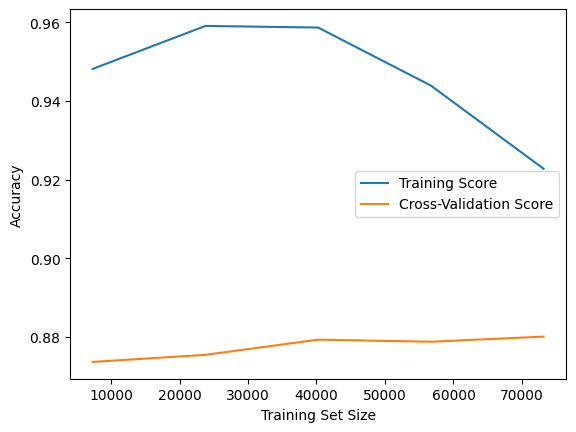

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    xgb_model,
    X,
    y,
    cv=5,
    scoring='accuracy',
    fit_params={'eval_set': [(X_test, y_test)]})

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Doesn't look too good.  No real convergence is pointing to an overfitting problem

# **This is sort of what I expected.  Like I talked about with Khanh, XGBoost really has a perpencity to overfit to the training data.  We can see that in the graph above.  We are not getting a good indication of convergence.  I just wanted to play around with XGBoosting out of curiosity though so I am not too worried about these results.  I even tried early stoppping to see if I could fix overfitting, but it was unsuccessful.**

**Future: Try to hyperparameterize tuning with CV or some regularization techniques to eliminate overfitting issue**

# Final Recap
If you look at both notebooks we see that Random Forest Classifier has done a lot better than Logistic Regression especially with precision.  

Logistical Regression assumes linear relationships between the features, and if the relationships are non-linear, then logistical regression will not perform as well as we expect, which we saw.  With non-linear complexities, Random Forest Classifiers are usually better.  An ensemble method that can build multiple decision trees and majority vote on the aggregation of those predictions can capture non-linear relationships and relationships between those features.  

Because the metrics are illustrating this, our data probably has more non-linear complex relationships that Logistical Regression cannot fit.  


Overall, Random Forests are more flexible and can adapt to a variety of data distributions and complexities, whereas logistical regression is constrained by its linear relationships.

Future Endeavors:
I think looking into the future because we are seeing non-linearity in the data, we should explore Non-Linear Models:
1. Support Vector Machines (SVM),
2. Gradient Boosting Machines (GBM),
3. Neural Networks.
And of course tune their hyperparameters and regularize.

# End of Modeling.  Thanks Khanh for helping along the way!